<a href="https://colab.research.google.com/github/tanishamish56/HFT-trade-scoring-system-using-DL-and-Ml/blob/main/major_project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("trades.csv")
print(df.head())
print(df.info())
print(df['label'].value_counts())

   accountAgeDays  numItems  localTime paymentMethod  paymentMethodAgeDays  \
0              29         1   4.745402        paypal             28.204861   
1             725         1   4.742303   storecredit              0.000000   
2             845         1   4.921318    creditcard              0.000000   
3             503         1   4.886641    creditcard              0.000000   
4            2000         1   5.040929    creditcard              0.000000   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39221 entries, 0 to 39220
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accountAgeDays        39221 non-null  int64  
 1   numItems              39221 non-null  int64  
 2   localTime             39221 non-null  float64
 3   paymentMethod         39221 non-null  object 
 4   paymentMethodAgeDays  39221 non-null  float64


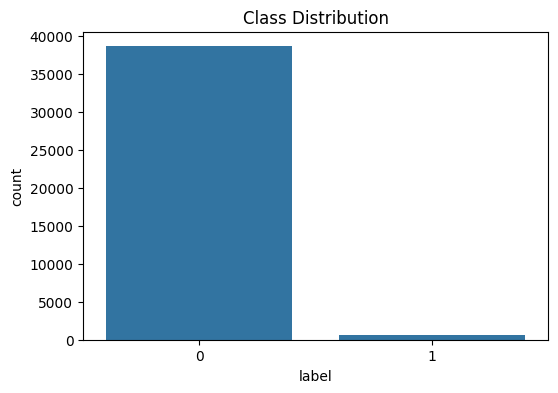

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.show()

In [15]:
fraud_ratio = df['label'].mean()
print("Fraud Percentage:", fraud_ratio*100)

Fraud Percentage: 1.427806532214885


In [16]:
df['account_to_payment_age_ratio'] = df['accountAgeDays'] / (df['paymentMethodAgeDays'] + 1)

In [17]:
df['is_new_account'] = df['accountAgeDays'].apply(lambda x: 1 if x < 30 else 0)

In [18]:
df['is_new_payment_method'] = df['paymentMethodAgeDays'].apply(lambda x: 1 if x < 7 else 0)

In [19]:
df['item_account_ratio'] = df['numItems'] / (df['accountAgeDays'] + 1)

In [20]:
df['hour'] = (df['localTime'] * 24).astype(int) % 24

def time_risk(hour):
    if hour >=0 and hour <=5:
        return 2   # High risk night hours
    elif hour >=6 and hour <=18:
        return 0   # Normal
    else:
        return 1   # Medium

df['time_risk_score'] = df['hour'].apply(time_risk)

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['paymentMethod'] = le.fit_transform(df['paymentMethod'])

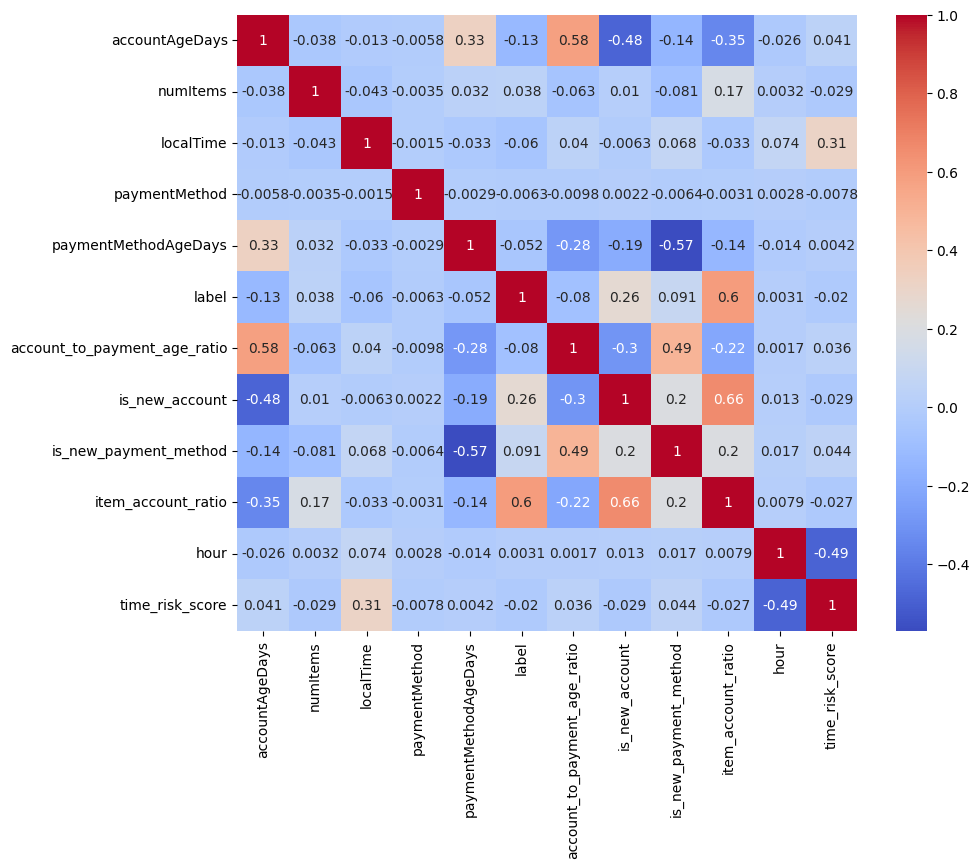

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [23]:
X = df.drop('label', axis=1)
y = df['label']

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    stratify=y,
    random_state=42
)

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

lr_probs = lr.predict_proba(X_test)[:,1]

print("LR AUC:", roc_auc_score(y_test, lr_probs))

LR AUC: 1.0


In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)

rf_probs = rf.predict_proba(X_test)[:,1]

print("RF AUC:", roc_auc_score(y_test, rf_probs))

RF AUC: 1.0


In [29]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=3
)

xgb.fit(X_train, y_train)

xgb_probs = xgb.predict_proba(X_test)[:,1]

print("XGB AUC:", roc_auc_score(y_test, xgb_probs))

XGB AUC: 1.0


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

dl_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

dl_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC']
)

dl_model.fit(X_train, y_train,
             epochs=25,
             batch_size=256,
             validation_split=0.2)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - AUC: 0.9154 - loss: 0.2951 - val_AUC: 0.0000e+00 - val_loss: 0.0023
Epoch 2/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9999 - loss: 0.0114 - val_AUC: 0.0000e+00 - val_loss: 3.5987e-04
Epoch 3/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 1.0000 - loss: 0.0027 - val_AUC: 0.0000e+00 - val_loss: 1.3618e-04
Epoch 4/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 1.0000 - loss: 0.0012 - val_AUC: 0.0000e+00 - val_loss: 6.6802e-05
Epoch 5/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 1.0000 - loss: 5.8809e-04 - val_AUC: 0.0000e+00 - val_loss: 2.6106e-05
Epoch 6/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 1.0000 - loss: 3.2231e-04 - val_AUC: 0.0000e+00 - val_loss: 2.2409e-05
Epoch 7/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 1.0000 - loss: 2.5727e-04 - val_AUC: 0.0000e+00 - val_loss: 1.0430e-05
Epoch 8/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 1.0000 - loss: 1.4754e-04 - val_AUC: 0.0000e+00 - 

In [31]:
dl_probs = dl_model.predict(X_test).flatten()

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [32]:
risk_score = (
    0.4 * xgb_probs +
    0.3 * rf_probs +
    0.2 * dl_probs +
    0.1 * lr_probs
)

risk_score = (risk_score - risk_score.min()) / (risk_score.max() - risk_score.min())

In [33]:
def classify(score):
    if score < 0.3:
        return "Low"
    elif score < 0.6:
        return "Medium"
    elif score < 0.8:
        return "High"
    else:
        return "Critical"

risk_category = [classify(x) for x in risk_score]

In [34]:
final_auc = roc_auc_score(y_test, risk_score)
print("Final Ensemble AUC:", final_auc)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, (risk_score>0.6).astype(int)))
print(classification_report(y_test, (risk_score>0.6).astype(int)))

Final Ensemble AUC: 1.0
[[7733    0]
 [   0  112]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7733
           1       1.00      1.00      1.00       112

    accuracy                           1.00      7845
   macro avg       1.00      1.00      1.00      7845
weighted avg       1.00      1.00      1.00      7845



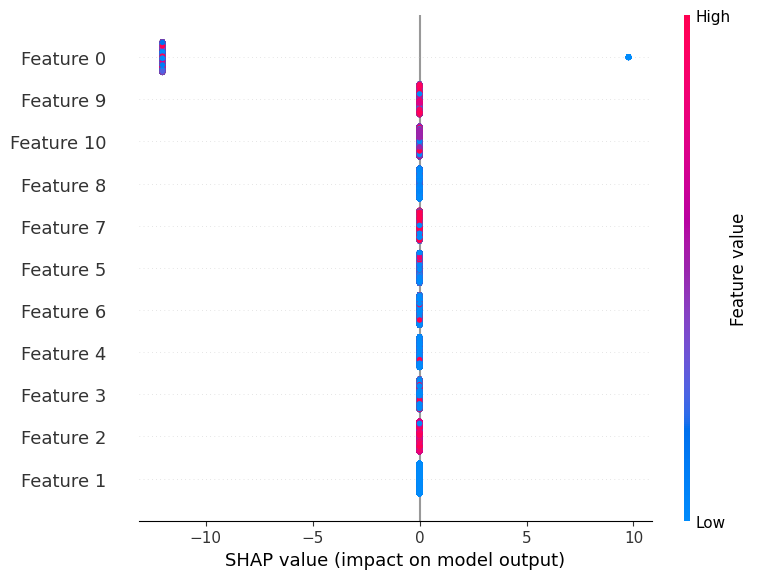

In [35]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [36]:
import joblib

joblib.dump(xgb, "xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")
dl_model.save("dl_model.h5")

In [37]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(X_train)

iso_scores = -iso.decision_function(X_test)

# Normalize
iso_scores = (iso_scores - iso_scores.min())/(iso_scores.max()-iso_scores.min())

In [38]:
X_train_normal = X_train[y_train==0]

autoencoder = tf.keras.Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(X_train.shape[1], activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train_normal, X_train_normal,
                epochs=30,
                batch_size=256,
                validation_split=0.2)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7941 - val_loss: 0.0660
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0402 - val_loss: 0.0134
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0115 - val_loss: 0.0078
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0077 - val_loss: 0.0054
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 9/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 10/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 11/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 12/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.00

In [39]:
reconstructed = autoencoder.predict(X_test)
ae_error = np.mean(np.square(X_test - reconstructed), axis=1)

ae_error = (ae_error-ae_error.min())/(ae_error.max()-ae_error.min())

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [40]:
final_risk_score = (
    0.35 * xgb_probs +
    0.20 * rf_probs +
    0.15 * dl_probs +
    0.10 * lr_probs +
    0.10 * iso_scores +
    0.10 * ae_error
)

final_risk_score = (final_risk_score - final_risk_score.min()) / \
                   (final_risk_score.max() - final_risk_score.min())

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, final_risk_score)

youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]

print("Best Threshold:", optimal_threshold)

Best Threshold: 0.8254271356883496


In [42]:
y_pred = (final_risk_score > optimal_threshold).astype(int)

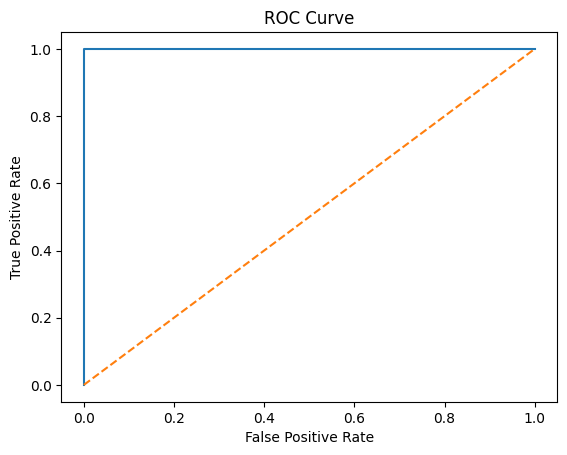

In [43]:
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

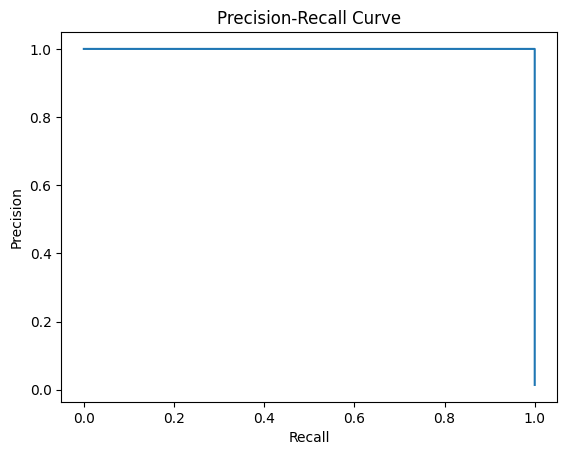

In [44]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, final_risk_score)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [45]:
import streamlit as st
import pandas as pd
import joblib
import numpy as np

st.title("Intelligent Transaction Risk Scoring System")

uploaded_file = st.file_uploader("Upload Transaction CSV")

if uploaded_file:
    data = pd.read_csv(uploaded_file)

    model = joblib.load("xgb_model.pkl")
    scaler = joblib.load("scaler.pkl")

    data_scaled = scaler.transform(data)
    risk = model.predict_proba(data_scaled)[:,1]

    data["Risk Score"] = risk

    st.write(data.sort_values("Risk Score", ascending=False))

2026-02-28 11:47:46.989 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-28 11:47:47.225 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-02-28 11:47:47.227 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-28 11:47:47.227 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-28 11:47:47.229 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-28 11:47:47.230 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-28 11:47:47.232 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-28 11:47:47.233 Thread 'MainThread': mi